# MLE

In [1]:
import math
import random
import statistics


import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns


import scipy
import scipy.stats as stats
from scipy.stats import binom, poisson, gamma
from scipy.optimize import curve_fit, fsolve

import statsmodels.api as sm

# Matplotlib settings
from matplotlib import rcParams
import zipfile


In [2]:
cm = 1/2.54
fs = 11
flf = 10*cm
fhf = 10*cm
plt.rc('axes', labelsize=fs, titlesize=fs)
plt.rc('xtick', labelsize=fs)
plt.rc('ytick', labelsize=fs)
plt.rc('legend', fontsize=fs)
plt.rc('figure', figsize=(flf,fhf))
plt.rcParams['legend.title_fontsize'] = fs
plt.rcParams["legend.labelspacing"] = 0.25
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

riso=1000

## Functions

In [3]:
def bootstrap_ci(x0, repetitions = 1000, alpha = 0.05, fun=np.median):
    
    import numpy.random as nprm
    
    '''
    Compute the bootstrap confidence interval for a given statistic (median)

    Parameters:
        x0 (array-like): Input data.
        repetitions (int): Number of bootstrap samples (default 1000).
        alpha (float): Significance level (default 0.05 for 95% CI).
        fun (callable): Statistic function to apply (default np.median).

        
    Returns:
        lower_bound, upper_bound, bootstrap_statistics_array
    '''
    x1 = np.array(x0)
    bootstrap_sample_size = x1.size

    x_ci = np.zeros(repetitions)
    for i in range(repetitions):
        x = nprm.choice(x1, size=bootstrap_sample_size, replace=True)
        x_ci[i] = fun(x)
     
 
    left = np.percentile(x_ci, (alpha/2)*100)
    right = np.percentile(x_ci, (100-((alpha/2)*100)))
    

    
    return left, right, x_ci

In [4]:
def compute_error(num_pos, num_tested, z_score=1.96):
    """
    Compute the confidence interval for a proportion using a normal approximation.

    Parameters:
        num_pos (int): Number of positive outcomes.
        num_tested (int): Total number of trials.
        z_score (float): Z-score for desired confidence level (default 1.96 for ~95%).

    Returns:
        tuple: (lower_bound, upper_bound)
    """
    p = num_pos / num_tested
    error = z_score * math.sqrt((p *(1-p))/num_tested)
    LB = p - error
    UB = p + error
    return LB, UB

In [5]:
def likelihood(beta, model, number_tested, number_tested_positive):
    p = 0
    for w in range(0, len(weeks)):
        subdf = model[beta]
        w1 = int(weeks[w][1:3])
        prev = subdf[subdf['week']==w1]['per'].values[0]
        if(prev!=0):
            p += binom.logpmf(number_tested_positive[w], number_tested[w], prev)
        else:
            p += binom.logpmf(number_tested_positive[w], number_tested[w], prev+0.000001)
        print(beta, weeks[w], prev, p)
    return p

In [6]:
def likelihood(beta, model, number_tested, number_tested_positive, weeks, verbose=False):
    """
    Compute the total log-likelihood for a given beta across multiple weeks.
    
    Parameters:
        beta (any): Key to select the model sub-dataframe.
        model (dict): Dictionary mapping beta to sub-dataframes.
        number_tested (array-like): Number tested each week.
        number_tested_positive (array-like): Number tested positive each week.
        weeks (list): List of week 
        

    Returns:
        float: Total log-likelihood.
    """
    log_likelihood = 0.0
    subdf = model[beta]
    
    for w_idx, week_label in enumerate(weeks):
        week_number = int(week_label[1:3])
        week_data = subdf[subdf['week'] == week_number]

        
        prev = week_data['per'].values[0]
        prev = max(prev, 1e-6)  # avoid zero probability

        log_likelihood += binom.logpmf(number_tested_positive[w_idx], number_tested[w_idx], prev)

        if verbose:
            print(f"beta={beta}, week={week_label}, prev={prev:.6f}, log_likelihood={log_likelihood:.4f}")

    return log_likelihood


In [7]:
def profile_likelihood_roots(z):
    x, y = z
    F = np.empty(2)
    F[0] = poly(mle_beta) - (3.84 / 2) - y
    F[1] = poly(x) - y
    return F

## Parameters

In [8]:
nsim = 2000 #nsim
cod = 11010 #protocol
ims = 0.35 #imm students
imt = 0.55 #imm teachers
vxs = 0.0 #vax. coverage students
vxt = 0.9
rbs = 0.35 #relative inf. for asymp. students
rbt = 0.55
rbcs = 0.63 #relative inf. for symp. students
rbct = 1.00
sgs = 0.5 #relative susc. for astudents
sgt = 1.0
pss = 0.80 #prob. to stay asymp. students
pst = 0.5
pds = 0.3
pdt = 0.5 #detection prob. students
t = 1440  #turnaround time
d = 7

ntimes=1
nweeks=1

betas=[0.012, 0.013, 0.014,  0.0155,  0.0165, 0.017, 0.018, 0.019]

nnodes=232
final_day=42

## Read data

In [17]:
# Read observed data
departments = ['Isere', 'Puy', 'Rhone', 'Savoie']

# Load total tests
with zipfile.ZipFile('data_in.zip') as z:
    with z.open('data_in/regular_tests_deps_w01-06.csv') as f:
        dfScreen_test = pd.read_csv(f, sep=';')
dfScreen_test['dep'] = departments

# Load positive tests
with zipfile.ZipFile('data_in.zip') as z:
    with z.open('data_in/regular_positive_deps_w01-06.csv') as f:
        dfScreen_pos = pd.read_csv(f, sep=';')
dfScreen_pos['dep'] = departments

weeks = ['W01', 'W02', 'W03', 'W04', 'W05', 'W06']
dfScreen_preva = pd.DataFrame(columns=['departments', 'W01', 'W02', 'W03', 'W04', 'W05', 'W06', 'dep'])


dfScreen_preva['departments'] = dfScreen_pos['departments'].values
dfScreen_preva['dep'] = dfScreen_pos['dep'].values

# Compute the prevalence for each week and store it in the corresponding column
for week in weeks:
    dfScreen_preva[week] = (dfScreen_pos[week] / dfScreen_test[week]) * 100


In [20]:
## Read test sensitivity
with zipfile.ZipFile('data_in.zip') as z:
    with z.open('data_in/sensitivity-PCR.csv') as f:
        df = pd.read_csv(f)
dfSensitivity = df.copy()

theta_p = dfSensitivity[dfSensitivity['compartment']=='Ip'].PCR_symp_child.tolist()
theta_c = dfSensitivity[dfSensitivity['compartment']=='Ic'].PCR_symp_child.tolist()
theta_s = dfSensitivity[dfSensitivity['compartment']=='Ic'].PCR_asymp_child.tolist()
theta_r = dfSensitivity[dfSensitivity['compartment']=='Rp'].PCR_asymp_child.tolist()

#print('theta_p : ', theta_p)
#print('theta_c : ', theta_c)
#print('theta_s : ', theta_s)
#print('theta_r : ', theta_r)
#df

## Model

In [23]:
#'Rhone' department - Omicron period
departments = ['Rhone']


In [28]:
model_Rhone = {}
models = {'Rhone': model_Rhone}

# Loop over departments
for dp in departments:
    model = models[dp]

    for beta in betas:

        with zipfile.ZipFile('data_out.zip') as z:
            filename = (
                f"posit_n{nsim}_b{beta:.4f}_{cod}_im{ims:.2f}_{imt:.2f}_Pd{pds:.1f}_{pdt:.1f}_"
                f"t{t}_d{d}_f{ntimes}_{nweeks}.txt"
            )
            with z.open('data_out/'+filename) as f:
                df = pd.read_csv(f, sep='\t', header=None)
        
        # Read the data
        
        df.columns = [
            'sim', 'day', 'den', 'ip1', 'ip2', 'ip3', 'ip4', 'ic1', 'ic2', 'ic3', 'ic4', 'ic5', 'ic6',
            'is1', 'is2', 'is3', 'is4', 'is5', 'is6', 'ir1', 'ir2', 'ir3', 'ir4'
        ]
        
        df = df[df['day'] <= final_day]

        
        df['Ip'] = df['ip1'] * theta_p[0]
        df['Is'] = sum(df[f'is{i+1}'] * theta_s[i] for i in range(6))
        df['Ic'] = sum(df[f'ic{i+1}'] * theta_c[i] for i in range(6))
        df['Rp'] = sum(df[f'ir{i+1}'] * theta_r[i] for i in range(4))
        
     
        df['I'] = df['Ip'] + df['Is'] + df['Ic'] + df['Rp']

       
        I_pivot = df.pivot(index='sim', columns='day')['I']
        den_pivot = df.pivot(index='sim', columns='day')['den']

        
        absolute_weekly_prevalence = []
        percentage_weekly_prevalence = []
        dw, up, pr = [], [], []

        # Weekly aggregation
        for day in range(0, final_day, 7):
            infections_day = I_pivot[day]
            denominator_day = den_pivot[day]

            median_infections = infections_day.median()
            median_present = denominator_day.median()
            prevalence_percent = (infections_day / denominator_day).median()

            # Bootstrap confidence interval
            wp = infections_day / denominator_day
            ci_low, ci_high, _ = bootstrap_ci(wp, repetitions=1000, alpha=0.05, fun=np.median)

            # Store results
            absolute_weekly_prevalence.append(median_infections)
            percentage_weekly_prevalence.append(prevalence_percent)
            pr.append(median_present)
            dw.append(ci_low * 100)
            up.append(ci_high * 100)

        # Create prevalence summary table
        preva_table = pd.DataFrame({
            'week': np.arange(1, 7),
            'abs': absolute_weekly_prevalence,
            'present': pr,
            'per': percentage_weekly_prevalence,
            'dw': dw,
            'up': up,
        })

        
        model[beta] = preva_table

In [31]:
Logl = []


weeks = dfScreen_pos.columns[1:7].tolist()

for dp in departments:
    
    # Test and positive counts
    number_tested = dfScreen_test[dfScreen_test['dep'] == dp][weeks].values[0].tolist()
    number_tested_positive = dfScreen_pos[dfScreen_pos['dep'] == dp][weeks].values[0].tolist()

    #print(dp, number_tested, number_tested_positive, 
    #      np.array(number_tested_positive) / np.array(number_tested))

    # Compute log-likelihoods
    logl_dep = [
        likelihood(beta, model, number_tested, number_tested_positive, weeks) 
        for beta in betas
    ]

    Logl.append(logl_dep)

points = [sum(Logl[dep_idx][beta_idx] for dep_idx in range(len(Logl))) for beta_idx in range(len(Logl[0]))]




In [32]:
#points

## Fit

MLE beta: 0.0153, CI lower: 0.0130, CI upper: 0.0176


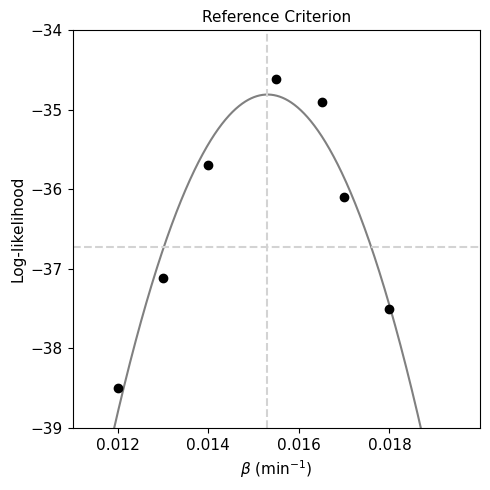

In [33]:

fig, ax = plt.subplots(figsize=(5, 5))

# Create likelihood dataframe
lh_df = pd.DataFrame({
    'beta': betas,
    'likelihood': [-x for x in points]  # negating if needed
})

# Quadratic fit
z = np.polyfit(betas, points, deg=2)
poly = np.poly1d(z)

# Extract coefficients
a, b, c = z


xs = np.linspace(betas[0] - 0.001, betas[-1] + 0.001, 1000)
ys = poly(xs)

# Find vertex 
vertex = xs[np.argmax(ys)]
mle_beta = vertex

threshold = poly(mle_beta) - (3.84 / 2)

# confidence interval
z1 = fsolve(profile_likelihood_roots, np.array([0, 0]))[0]
z2 = fsolve(profile_likelihood_roots, np.array([1, 1]))[0]

print(f"MLE beta: {mle_beta:.4f}, CI lower: {z1:.4f}, CI upper: {z2:.4f}")


# Plot 
ax.scatter(betas, points, color='black', label='Data')
ax.set_xlabel(r'$\beta$ (min$^{-1}$)')
ax.set_ylabel('Log-likelihood')
ax.plot(xs, ys, color='grey', label='Quadratic fit', zorder=0)
ax.axvline(mle_beta, color='lightgrey', linestyle='--')
ax.axhline(threshold, color='lightgrey', linestyle='--')

ax.set_ylim([-39, -34])
ax.set_xlim([betas[0] - 0.001, betas[-1] + 0.001])
ax.set_xticks(np.arange(0.012, 0.02, 0.002))
ax.set_title('Reference Criterion')

plt.tight_layout()
plt.show()


In [34]:
llf = np.max(ys)

# AIC 
nobs = nsim        # Number of observations
df_modelwc = 1     # Degrees of freedom (number of parameters estimated)

aic_value = sm.tools.eval_measures.aic(llf, nobs, df_modelwc)
print(f"AIC: {aic_value:.2f}")

AIC: 71.61


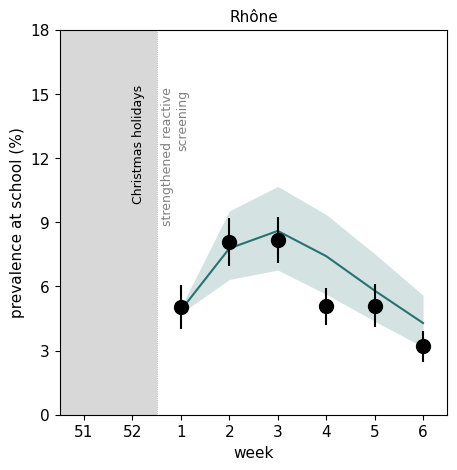

In [35]:
# Estimated prevalence at MLE


with zipfile.ZipFile('data_out.zip') as z:
            filename = (
                f"posit_n{nsim}_b{mle_beta:.4f}_{cod}_im{ims:.2f}_{imt:.2f}_Pd{pds:.1f}_{pdt:.1f}_"
            f"t{t}_d{d}_f{ntimes}_{nweeks}.txt"
            )
            with z.open('data_out/'+filename) as f:
                df_mle = pd.read_csv(f, sep='\t', header=None)

df_mle.columns = ['sim', 'day', 'den', 'ip1', 'ip2', 'ip3', 'ip4',
              'ic1', 'ic2', 'ic3', 'ic4', 'ic5', 'ic6',
              'is1', 'is2', 'is3', 'is4', 'is5', 'is6',
              'ir1', 'ir2', 'ir3', 'ir4']

df_mle = df_mle[df_mle['day'] <= final_day]


df_mle ['Ip'] = df_mle ['ip1'] * theta_p[0]
df_mle ['Is'] = sum(df_mle [f'is{i+1}'] * theta_s[i] for i in range(6))
df_mle ['Ic'] = sum(df_mle [f'ic{i+1}'] * theta_c[i] for i in range(6))
df_mle ['Rp'] = sum(df_mle [f'ir{i+1}'] * theta_r[i] for i in range(4))
df_mle ['I'] = df_mle ['Ip'] + df_mle ['Is'] + df_mle ['Ic'] + df_mle ['Rp']

dfp = df_mle.pivot(index='sim', columns='day')['I']
dfp_den = df_mle.pivot(index='sim', columns='day')['den']

absolute_weekly_prevalence = []
percentage_weekly_prevalence = []
up, dw = [], []

for i in np.arange(0, final_day, 7):
    infections = dfp.loc[:, i]
    presence = dfp_den.loc[:, i]

    median_abs = infections.median()
    median_per = (infections / presence).median()

    absolute_weekly_prevalence.append(median_abs)
    percentage_weekly_prevalence.append(median_per)

    wp = infections / presence
    dw.append(wp.quantile(0.25) * 100)
    up.append(wp.quantile(0.75) * 100)

preva_table_mle = pd.DataFrame({
    'week': np.arange(1, 7),
    'abs': absolute_weekly_prevalence,
    'per': percentage_weekly_prevalence,
    'up': up,
    'dw': dw
})


# Observed prevalence
obs_preva = dfScreen_preva[dfScreen_preva['dep'] == departments[0]][weeks].values[0]
# Observed prevalence - Error bars
LB, UB = [], []
for week in weeks:
    lb, ub = compute_error(
        dfScreen_pos[dfScreen_pos['dep'] == departments[0]][week].values[0],
        dfScreen_test[dfScreen_test['dep'] == departments[0]][week].values[0]
    )
    LB.append(lb * 100)
    UB.append(ub * 100)

#PLot
plt.figure(figsize=(5, 5))
plt.plot(preva_table_mle['week']-1, preva_table_mle['per'] * 100, lw=1.5, color='#287271', 
         label='model', zorder=0)
plt.fill_between(preva_table_mle['week']-1, preva_table_mle['up'], preva_table_mle['dw'], 
                 color='#287271', alpha=0.2, linewidth=0.0, zorder=1)

plt.scatter(np.arange(len(obs_preva)), obs_preva, marker='o', s=100, color='black', label='Observed data', zorder=2)
plt.vlines(np.arange(len(obs_preva)), LB, UB, color='black')

plt.title(dfScreen_preva[dfScreen_preva['dep'] == departments[0]]['departments'].values[0])
plt.ylabel('prevalence at school (%)')
plt.xlabel('week')

plt.xticks(np.arange(-2, len(preva_table),1), labels=[51, 52, 1 ,2 ,3, 4, 5, 6 ])
plt.axvspan(-2.5, -0.5, facecolor='grey', zorder=-1, alpha=0.3)
plt.text(-1, 10, 'Christmas holidays', rotation='vertical', fontsize=9)

plt.xlim([-2.5, 5.5])
plt.axvline(-0.50, linestyle=':', color='grey', linewidth=0.5, zorder=0)
plt.text(-0.4, 9, 'strengthened reactive', color='grey', rotation='vertical', fontsize=9)
plt.text(-0.1, 12.5, 'screening', color='grey', rotation='vertical', fontsize=9)
plt.yticks(np.arange(0, 21, 3))
plt.show()


## School transmission

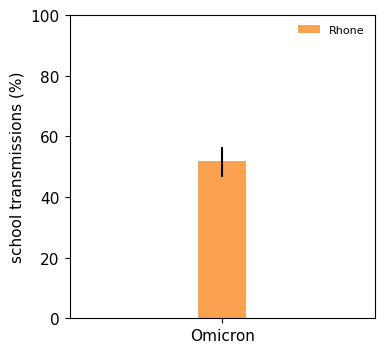

In [40]:
colors = ['#fb8b24']
contribution_rows = []
filename0 = 'regular_intro_stud_rr0.93_Rhone.txt'               
filename1 = f"intros_stn{nsim}_b{mle_beta:.4f}_{cod}_im{ims:.2f}_{imt:.2f}_Pd{pds:.1f}_{pdt:.1f}_t{t}_d{d}_f{ntimes}_{nweeks}.txt"
filename2 = f"trasm_stn{nsim}_b{mle_beta:.4f}_{cod}_im{ims:.2f}_{imt:.2f}_Pd{pds:.1f}_{pdt:.1f}_t{t}_d{d}_f{ntimes}_{nweeks}.txt"

with zipfile.ZipFile('data_in.zip') as z:
    with z.open('data_in/'+filename0) as f:
        intros_e = pd.read_table(f,sep='\t', header=None)

with zipfile.ZipFile('data_out.zip') as z:
    with z.open('data_out/'+filename1) as f1:
        intros_a = pd.read_table(f1,sep='\t', header=None)
    with z.open('data_out/'+filename2) as f2:
        trasm_a = pd.read_table(f2,sep='\t', header=None)

num = trasm_a.sum(axis=1)
den = trasm_a.sum(axis=1) + intros_a.sum(axis=1)

#print(f"num: {num.mean():.2f}, den: {den.mean():.2f}")
#print('school contribution {:.2f}%, 25%: {:.2f}%, 75%: {:.2f}%'.format(
#    (num/den).median() * 100,
#    (num/den).quantile(0.25) * 100,
#    (num/den).quantile(0.75) * 100
#))

# Store result in a  DataFrame
#contribution_rows.append({
#    'dep': int(n),
#    'w1': 1,
#    'w2': 6,
#    'school': (num/den).median() * 100,
#    'school_q1': (num/den).quantile(0.25) * 100,
#    'school_q2': (num/den).quantile(0.75) * 100
#})

# Plot
j=0
plt.bar(j, (num/den).median() * 100, color=colors[0], width=0.175, alpha=0.8, label=f'{departments[0]}' if j == 0 else "")
plt.vlines(j, (num/den).quantile(0.25) * 100, (num/den).quantile(0.75) * 100, color='black')


print('\n')


#contribution = pd.DataFrame(contribution_rows)

plt.yticks(np.arange(0, 120, 20))
plt.xticks(np.arange(-1, 1, 1), labels=['', 'Omicron'])
plt.ylim([0, 100])
plt.xlim([-0.55, 0.55])
plt.ylabel('school transmissions (%)')

plt.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=8)
plt.show()
